In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
import tensorflow as tf
from pathlib import Path
from time import strftime, time
from shutil import rmtree
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
#matplotlib.use("TKAgg", force=True)
%matplotlib inline
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [10]:
import sys
sys.path.append('/data01/homes/baroncelli/phd/cta-sag-sci')

In [11]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.plotting.plotting import plot_sequences, plot_nn_metrics
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_from_pvalue, get_sigma_for_ts_array, get_sigma_from_ts
from rtapipe.lib.utils.notebook import *
from sagsci.tools.utils import get_obs_pointing
from sagsci.wrappers.rtaph.photometry import Photometrics

from rtapipe.lib.plotting.PlotConfig2 import PlotConfig2
from rtapipe.lib.utils.notebook import (
    load_model, 
    plot_timeseries,
    plot_nn_metrics2,
    crop_to_5,
    get_templates_detections,
    filter_templates,
    get_dd,
    evaluate_metrics
)

# Loading the models

In [12]:
model_config_cnn = load_model(0)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 0,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19',
 'epoch': 19,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19/pvalues/pval_20221118-113940/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2b6714204430>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.003171       0.000

In [13]:
model_config_cnn.ad.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 32)             320       
_________________________________________________________________
dropout (Dropout)            (None, 3, 32)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 32)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 5, 3)              291       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 3)              0         
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_config_rnn = load_model(1)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 1,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10',
 'epoch': 10,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10/pvalues/pval_20221121-132236/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2b6765f2e340>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000227       0.000

# Loading the test dataset

In [15]:
output_dir = "./logs/new_notebook_2024_integration_time_5"
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]
Path(output_dir).mkdir(exist_ok=True)
data_manager = DataManager(output_dir)
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/test_set_easy/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=500)
test_set_size = len(fits_files)
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 5
number_of_energy_bins = 3
tsl = 100
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(5, 100)

Loaded 419 files
Loading data from logs/new_notebook_2024_integration_time_5/data_cache. Found 419 files.
[2024-01-27 17:27:07.078649] Loaded data from logs/new_notebook_2024_integration_time_5/data_cache. Loaded 419 templates.


## Plot some samples

In [16]:
templates_under_investigation = [
    "run0535_ID000181", "run0222_ID000318", "run0340_ID000060", "run0453_ID000359", # BOMBS
    "run0050_ID000319", "run0276_ID000042", "run0481_ID000069", "run0522_ID000294", # AD GOOD
    "run0266_ID000397", "run0051_ID000166", "run0231_ID000152", "run0170_ID000418", # GOOD AGREEMENT
    "run0077_ID000381", "run0101_ID000172", "run0158_ID000313", "run0276_ID000003", # AD not so good
    "run0352_ID000076", "run0421_ID000208", "run0428_ID000157", "run0615_ID000245"  # AD bad
]

In [ ]:
for template in tqdm(templates_under_investigation):
    plot_timeseries(template, data_manager.data[template], 1, sim_params, Path(output_dir).joinpath("timeseries"), labels=features_names)

# TESTING

In [17]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [18]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2024-01-27 17:27:07.339736] Total x shape shape: (40224, 5, 3)
[2024-01-27 17:27:07.339810] Total y shape shape: (40224,)


In [19]:
test_all_y.sum()

20531

# PValue table RNN

In [33]:
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

,threshold,pvalue,pvalue_err,sigma
0,0.000227,1.416930e-01,1.254772e-04,1.073
1,0.000253,9.859137e-02,1.046671e-04,1.290
2,0.000279,6.802256e-02,8.693953e-05,1.491
3,0.000305,4.666059e-02,7.200554e-05,1.678
4,0.000331,3.223601e-02,5.984963e-05,1.849
...,...,...,...,...
87,0.002495,1.111173e-07,1.111173e-07,5.180
88,0.002521,1.111173e-07,1.111173e-07,5.180
89,0.002547,1.111173e-07,1.111173e-07,5.180
90,0.002574,1.111173e-07,1.111173e-07,5.180


In [ ]:
#tmpdf=model_config_rnn.pvalue_table.drop_duplicates(subset=['sigma']) 
tmpdf=tmpdf.loc[tmpdf.round().drop_duplicates().index]
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)
print(tmpdf)
tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0.99)   & 
    (tmpdf['sigma'] < 1.1) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.007) |
    (tmpdf['sigma'] > 3.47) &
    (tmpdf['sigma'] < 3.52) |
    (tmpdf['sigma'] > 3.95) &
    (tmpdf['sigma'] < 4.070) |
    (tmpdf['sigma'] > 4.465) &
    (tmpdf['sigma'] < 4.534) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_rnn.tex", header=False, index=False)
! cat "pvalue_table_rnn.tex"

# PValue table CNN

In [ ]:
tmpdf=model_config_cnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 1)   & 
    (tmpdf['sigma'] < 1.2) |
    (tmpdf['sigma'] > 1.45) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.95) &
    (tmpdf['sigma'] < 2.084) |
    (tmpdf['sigma'] > 2.481) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.97) &
    (tmpdf['sigma'] < 3.09) |
    (tmpdf['sigma'] > 3.49) &
    (tmpdf['sigma'] < 3.555) |
    (tmpdf['sigma'] > 3.961) &
    (tmpdf['sigma'] < 4.051) |
    (tmpdf['sigma'] > 4.463) &
    (tmpdf['sigma'] < 4.51) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.048) 
]


tmpdf.to_latex("pvalue_table_cnn.tex", header=False, index=False)
! cat "pvalue_table_cnn.tex"

# Reconstructions RNN

In [ ]:

def plot_predictions(samples, samplesLabels, c_threshold, recostructions, mse_per_sample, mse_per_sample_features, features_names=["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"], integration_time=5, epoch="", max_plots=5, start_from=0, showFig=False, saveFig=True, outputDir="./", figName="predictions.png"):

    pc = PlotConfig2()

    total_samples = samples.shape[0]
    
    max_samples = 5
    n_features = samples.shape[2]
    if len(features_names) != n_features:
        features_names = [f"Feature {i}" for i in range(n_features)]

    num_plots = total_samples // max_samples
    print("num_plots:",num_plots)

    mask = (mse_per_sample > c_threshold)
    max_plots += start_from
    start = 0
    for p in tqdm(range(start_from, num_plots)):

        if p == max_plots:
            print("Max plots reached")
            break



                
        annotations = [f"{i*integration_time}-{i*integration_time+samples.shape[1]}" for i in range(0,101)]
        xticks = [i*5 for i in range(0,101)]

        current_samples = samples[start:start+max_samples, :, :]
        current_samplesLabels = samplesLabels[start:start+max_samples]
        current_samples_annotations = annotations[start:start+integration_time]
        print(current_samples_annotations)
        current_samples_xticks = xticks[start:start+max_samples]
        current_recostructions = recostructions[start:start+max_samples, :, :]
        current_mask = mask[start:start+max_samples]
        current_mse_per_sample_features = mse_per_sample_features[start:start+max_samples]
        current_mse_per_sample = mse_per_sample[start:start+max_samples]

        #print("current_samples:",current_samples)
        #print("current_mse_per_sample_features: ", current_mse_per_sample_features)
        start += max_samples

        ymax, ymin = 1, 0
        
        #print(f"Plot {p}. \nNumber of predictions: {len(current_samples)}. \nSample shape: {current_samples.shape} \n Number of features: {n_features}")

        real_labels = ["grb" if lab==1 else "bkg" for lab in current_samplesLabels ]
        pred_labels = ["grb" if lab==1 else "bkg" for lab in current_mask          ]

        fig, ax = plt.subplots(n_features, max_samples, figsize=(pc.fig_size[0]*1.5,pc.fig_size[1]*1.5))
        fig.suptitle(f"5σ threshold={round(c_threshold, 3)}")
        #fig.suptitle(f"Predictions (using threshold={round(c_threshold, 3)})")
        fig.supylabel('Energy bins (TeV)')

      

        # For each feature..
        for f in range(n_features):

            for i in range(max_samples):

                # Get a sample and its recostruction
                sample = current_samples[i][:,f]
                recoSample = current_recostructions[i][:,f]
                #print(i,f,len(sample))
                #print(i,f,len(recoSample))
                #print(current_samples_annotations)
                # And plot them                
                ax[f, i].plot(recoSample, color='red',  marker='o', markersize=6, linestyle='dashed', label="reconstruction")
                ax[f, i].plot(sample,     color="blue", marker='o', markersize=6, linestyle='dashed', label="ground truth")
                ax[f, i].set_ylim(ymin, ymax)

                #print(current_samples_xticks)
                ax[f, i].set_xticks(range(len(recoSample)), current_samples_annotations, fontsize=10)

                if real_labels[i] != pred_labels[i]:
                    ax[f, i].set_facecolor('#e6e6e6')

                # Only the first column will show the Y labels
                if i == 0:
                    ax[f, i].set_ylabel(features_names[f].split("EB_")[1].split(" TeV")[0])


                ax[f, i].set_xlabel("mse={:.6f}".format(current_mse_per_sample_features[i, f]))

                # Only the first row will show the TN/FP/FN/TP labels and the averaged mse
                if f == 0:
                    title = "Sample {}\nW. avg mse={:.5f}\nClassification=".format(start+i-max_samples, current_mse_per_sample[i])
                    if real_labels[i] == "grb" and real_labels[i] == pred_labels[i]:
                        title += "TP"
                    elif real_labels[i] == "grb" and real_labels[i] != pred_labels[i]:
                        title += "FN"
                    elif real_labels[i] == "bkg" and real_labels[i] == pred_labels[i]:  
                        title += "TN"
                    elif real_labels[i] == "bkg" and real_labels[i] != pred_labels[i]:
                        title += "FP"
                    ax[f, i].set_title(title)

        handles, labels = ax[f, i].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left')

        plt.tight_layout()

        if showFig:
            plt.show()

        if saveFig:
            Path(outputDir).mkdir(parents=True, exist_ok=True)
            outputPath = Path(outputDir).joinpath(f"{figName}_plot_{p}.svg")
            fig.savefig(outputPath)
            outputPath = Path(outputDir).joinpath(f"{figName}_plot_{p}.jpeg")
            fig.savefig(outputPath)
        plt.close()

print(f"\n\n************** Predictions with {model_config_rnn.name} patience={model_config_rnn.patience} **************")

plot_predictions(test_all_x, test_all_y, model_config_rnn.ad.threshold, model_config_rnn.ad.reconstruct(test_all_x),\
                 model_config_rnn.ad.loss_f.mse_per_sample.numpy(), \
                 model_config_rnn.ad.loss_f.mse_per_sample_features.numpy(), \
                 features_names=features_names, max_plots=200, start_from=0, epoch=model_config_rnn.epoch, \
                 outputDir=Path(output_dir).joinpath("reconstructions"),\
                 figName=f"{model_config_rnn.name}_itime_5", showFig=False, saveFig=True)


# Metrics RNN

In [ ]:
metrics_rnn = evaluate_metrics(model_config_rnn, test_all_x, test_all_y, output_dir, "metrics_rnn.pickle")#, additional_tresholds=[0, 0.000025, 0.000050, 0.000075])
metrics_rnn

In [ ]:
%matplotlib inline
plot_nn_metrics2(
    metrics_rnn, 
    model_config_rnn, 
    output_dir, 
    fig_name="rnn_metrics_test_set_all_itime_5", 
    y_lim=(0.01, 1.15), 
    annotate_after=0, 
    title="Performance metrics for the RNN autoencoder", 
    axtitle="Short-exposure scenario (integration time = 5 seconds)",    
    showFig=True, 
    saveFig=True
)

In [26]:
SIGMA_THRESHOLD = 5
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

In [28]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0020782086315
accuracy 0.6180887032617343
precision 0.9982648930017352
recall 0.25220398421898593
f1 0.402675169142235
roc_auc 0.6258734845179631
confusion_matrix [[19684, 9], [15353, 5178]]
false_positive_rate 0.001735106998264893
detection_delay: 2.4463007159904535


# Metrics CNN

In [30]:
metrics_cnn = evaluate_metrics(model_config_cnn, test_all_x, test_all_y, output_dir, "metrics_cnn.pickle")#, additional_tresholds=[0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.002])

Using threshold 0.0031706236489999
Using threshold 0.004621198509
Using threshold 0.006506945827
Using threshold 0.0091179805749999
Using threshold 0.0139048776129999
Generating output file:  logs/test_models_dataset_test_set_all_itime_5___03_09_23/metrics_cnn.pickle


In [31]:
plot_nn_metrics2(
    metrics_cnn, 
    model_config_cnn, 
    output_dir, 
    fig_name="cnn_metrics_test_set_all_itime_5", 
    annotate_after=0,
    title="Performance metrics for the CNN autoencoder", 
    axtitle="Short-exposure scenario (integration time = 5 seconds)",
    y_lim=(0.01, 1.15), showFig=True, saveFig=True)

NameError: name 'plot_nn_metrics2' is not defined

In [32]:
SIGMA_THRESHOLD = 5
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

In [33]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

Threshold: 0.0139048776129999 corresponding to 5.0465140766 sigma


# Sigma table RNN

In [29]:
if Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_5.csv").exists():
    sigma_table_rnn = pd.read_csv(Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_5.csv"), index_col=0)
else:
    data = {}
    for template in tqdm(list(data_manager.data.keys())):
        test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
        model_config_rnn.ad.predict(test_x)
        data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

    sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))
    # sigma_table_rnn = fix_independence(sigma_table_rnn)
    sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)
    sigma_table_rnn.to_csv(Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_5.csv"))


# Sigma table CNN

In [28]:
if Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_5.csv").exists():
    sigma_table_cnn = pd.read_csv(Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_5.csv"), index_col=0)
else:
    data = {}
    for template in tqdm(list(data_manager.data.keys())):
        test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
        model_config_cnn.ad.predict(test_x)
        data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

    sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1)) 
    # sigma_table_cnn = fix_independence(sigma_table_cnn)
    sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)   
    sigma_table_cnn.to_csv(Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_5.csv"))
    sigma_table_cnn

# Li&Ma

In [30]:
li_ma_data = {}
#templates = list(data_manager.data.keys())
templates = []

LiMa_detect_p = partial(LiMa.detect, "binned", integration_time, 99999, sigma_table_rnn.index.values, 500, 0, False, 0.2, [0.03, 1])
start = time()
with multiprocessing.Pool() as p:
    values = p.map(LiMa_detect_p, [DataManager.get_fits_from_template(fits_files, template) for template in templates])

for i, template in enumerate(templates):
     li_ma_data[template] = values[i]["sigma"].values   

print(f"Took {time()-start} s")
    
#
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_rnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_5.csv"))    
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_5.csv"), index_col=0)
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
# lima_sigma_table = fix_independence(lima_sigma_table, 25)
lima_sigma_table    

Took 2.511248826980591 s


,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

In [31]:
templates_detections = get_templates_detections(sigma_table_rnn, sigma_table_cnn, lima_sigma_table)

# Serendipitous discoveries

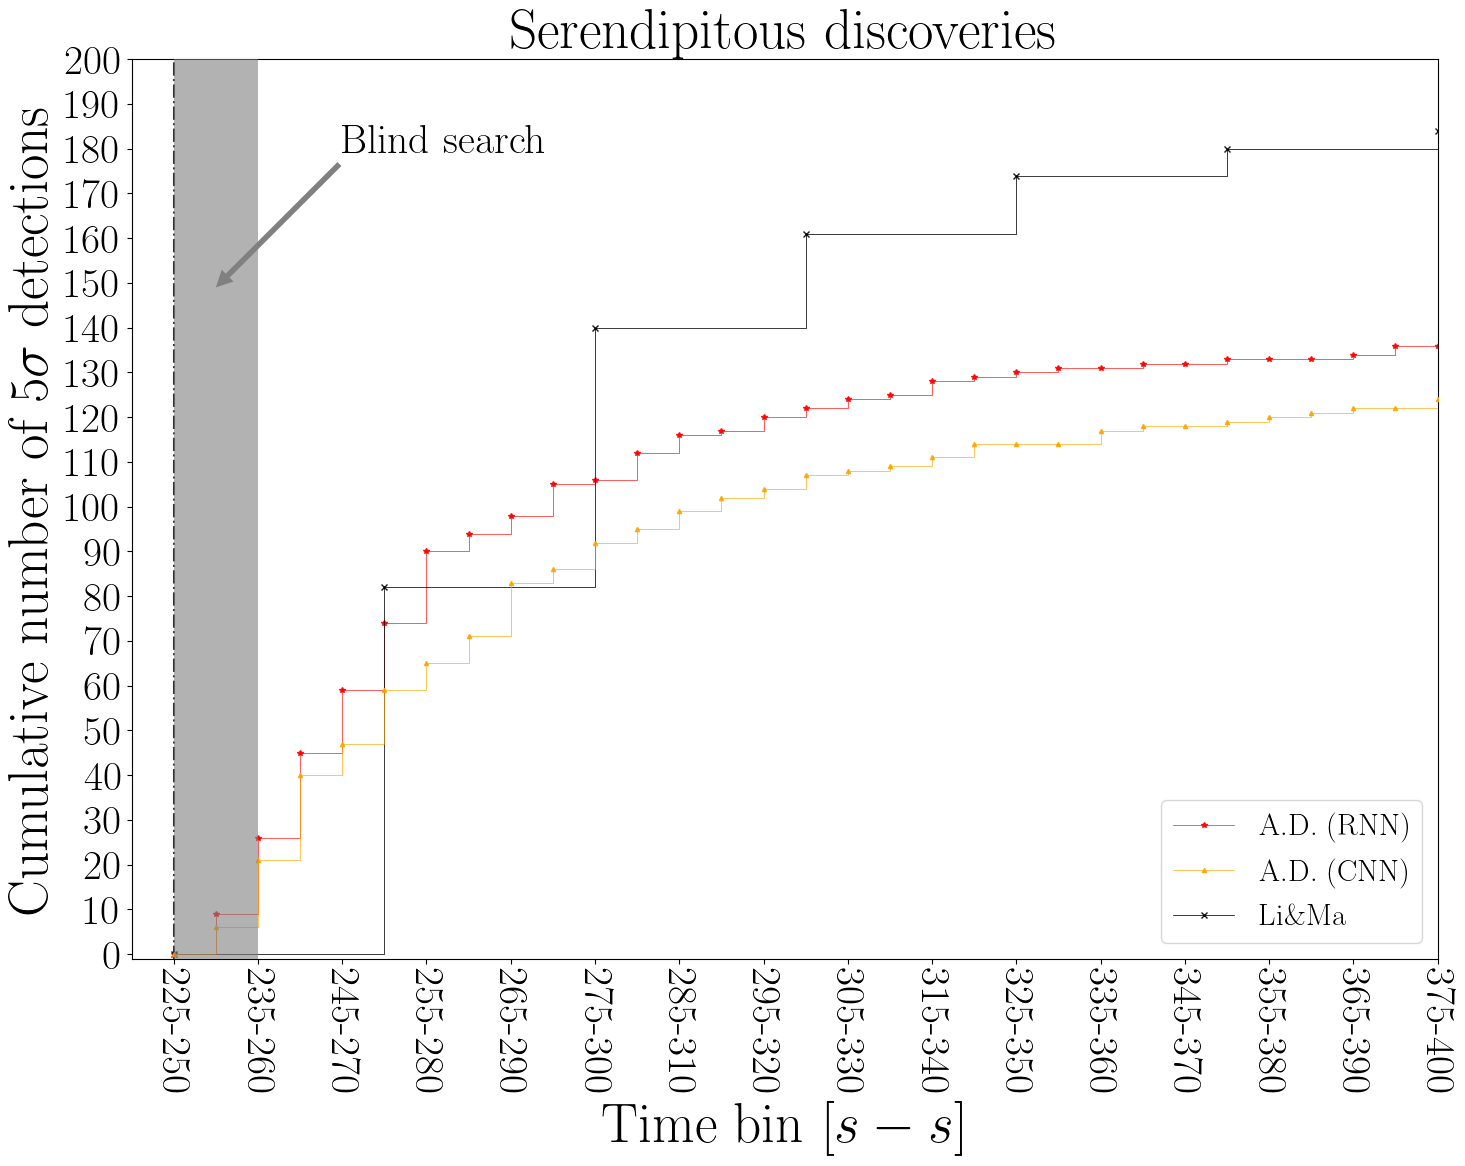

In [18]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches
SIGMA=5
def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig2()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel(r"Cumulative number of $5\sigma$ detections", fontsize=40)
    
    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=40)
    ax.set_title(r"Serendipitous discoveries", fontsize=40)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=4, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=2)
    
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li\&Ma", color="black", alpha=0.9, zorder=2)

    xticks_x = [i for i in range(45,96,2)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=30)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=30)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 25, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], 
                                 add_rectangle[1], 
                                 add_rectangle[2], 
                                 linewidth=0, 
                                 facecolor="grey", 
                                 alpha=0.6, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 30, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 200)

    ax.legend(markerscale=1, loc="best")
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5.pdf"))
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5.png"), dpi=pc.dpi)
    
rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(45,96,1)]
lima_bins = [i for i in range(45,96,5)]

for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )
    
cumulative_detections_plot(44, 75, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(45, -1), 2, 201])    

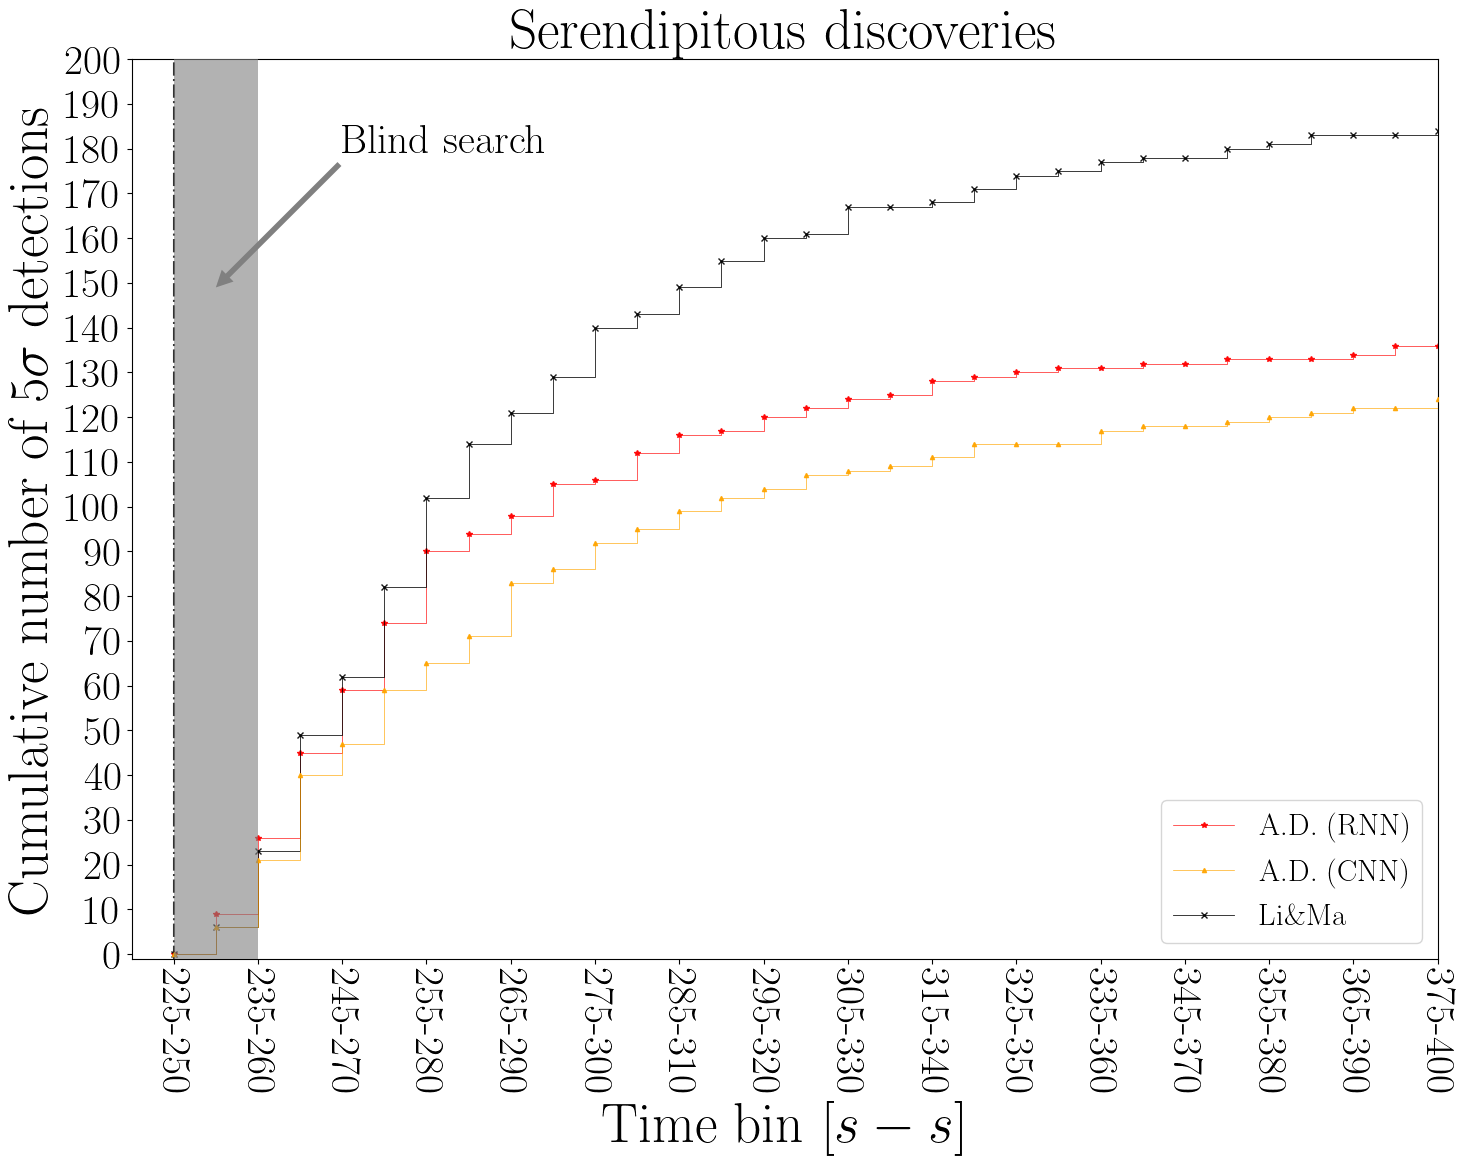

In [16]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches
SIGMA=5
def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig2()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel(r"Cumulative number of $5\sigma$ detections", fontsize=40)
    
    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=40)
    ax.set_title(r"Serendipitous discoveries", fontsize=40)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=4, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=2)
    
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li\&Ma", color="black", alpha=0.9, zorder=2)

    xticks_x = [i for i in range(45,96,2)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=30)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=30)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 25, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], 
                                 add_rectangle[1], 
                                 add_rectangle[2], 
                                 linewidth=0, 
                                 facecolor="grey", 
                                 alpha=0.6, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 30, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 200)

    ax.legend(markerscale=1, loc="best")
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5_same_bins.pdf"))
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5_wo_independence.png"), dpi=pc.dpi)
    
rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(45,96,1)]
lima_bins = [i for i in range(45,96,1)]

for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )
    
cumulative_detections_plot(44, 75, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(45, -1), 2, 201])    

In [ ]:
#SIGMA = 5
#ONSET_INDEX=45
#TMIN = 0
#TMAX = [47,50,55,60,65,70]
#detection_tables(SIGMA,ONSET_INDEX,TMIN,TMAX)

In [ ]:
ONSET_INDEX = 47
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [50,55,60,65,70])

In [ ]:
ONSET_INDEX = 47
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [50,55,60,65,70])

In [ ]:
ONSET_INDEX = 47
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [50,55,60,65,70])

# Follow-up observations

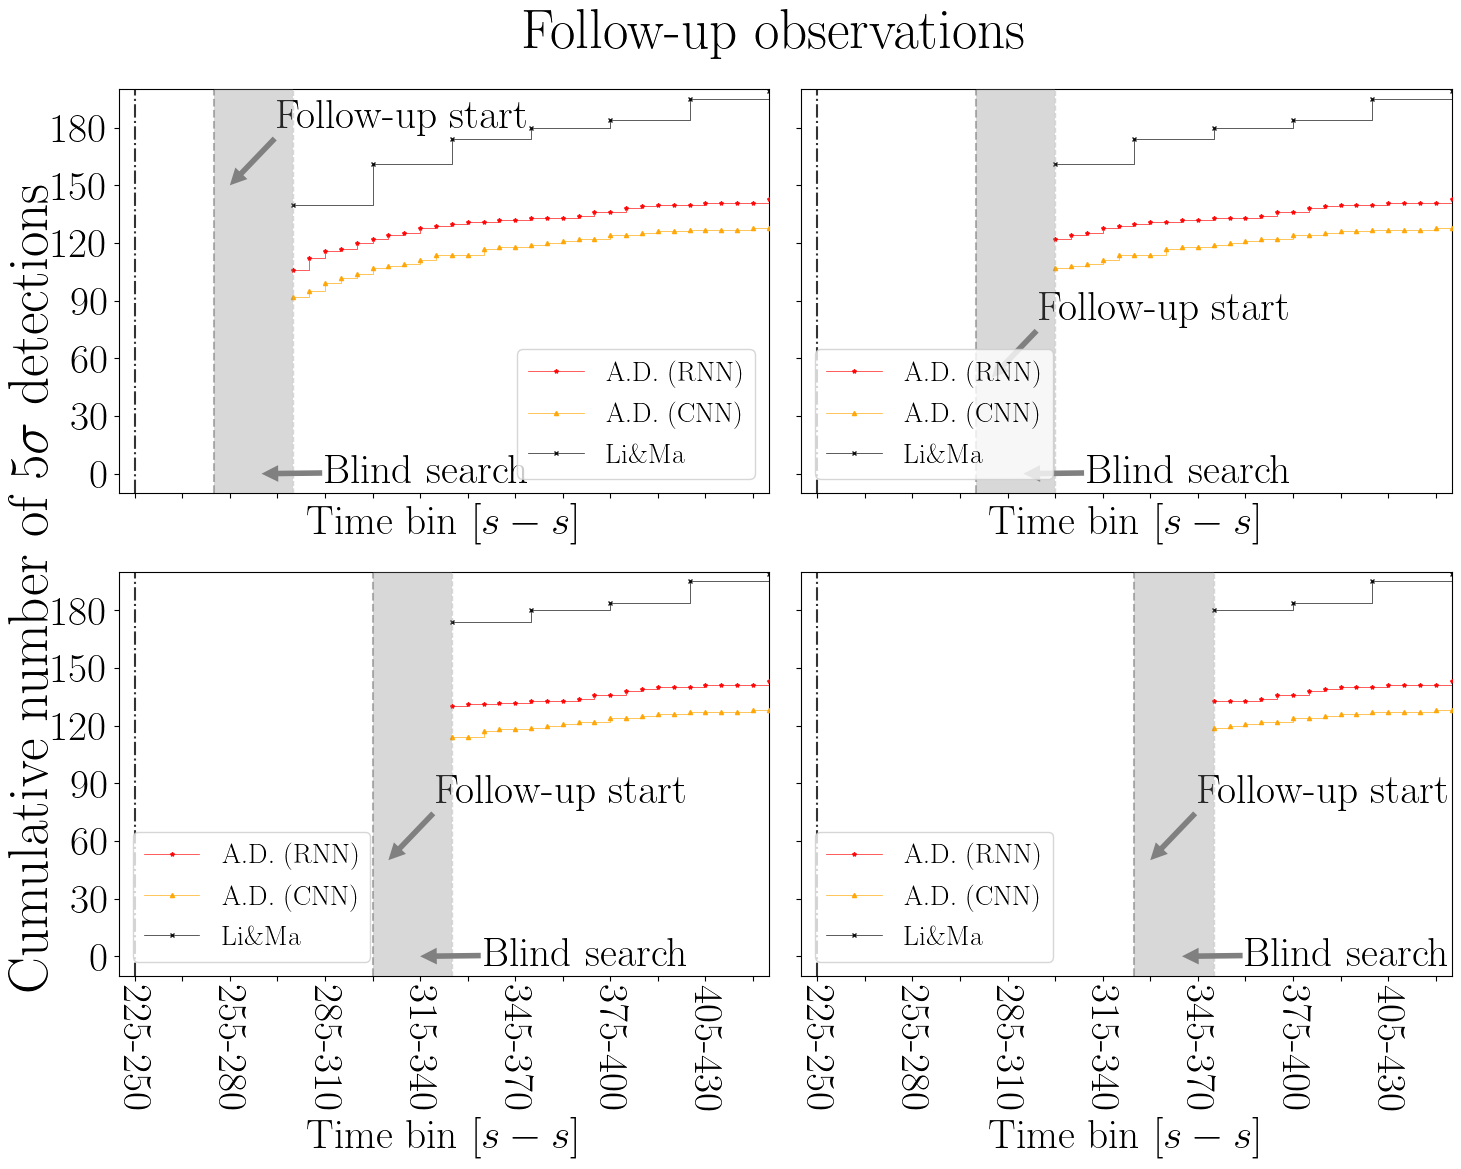

In [90]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches
SIGMA=5
def compute_number_of_detections(tstart):
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,96,1)]
    lima_bins = [i for i in range(tstart,96,5)]

    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
        )
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=30)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=4)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=3, linewidth=0.5, linestyle="-", 
            label="Li\&Ma", color="black", alpha=0.9, zorder=2)

    xticks_x = [i for i in range(45,96,3)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" if i%2!=0 else "" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=30)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,30)])
    yticks_labels = np.array([i for i in yticks_y])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=30)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 60:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 150), fontsize = 30, xytext = (vertical_line_x-5+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 50), fontsize = 30, xytext = (vertical_line_x-5+4, 80), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, 
                                 facecolor="grey", alpha=0.3, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+3, add_rectangle[0][1]+10), fontsize = 30, xytext = (add_rectangle[0][0]+7, add_rectangle[0][1]+5), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(44, stop)
    ax.set_ylim(-10, 200)

    if start < 60:
        ax.legend(markerscale=1, loc="lower right", prop={'size': 20})
    else:
        ax.legend(markerscale=1, loc="lower left", prop={'size': 20})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig2()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(r"Follow-up observations", fontsize=40)
    
    blind_search_grey_rects = [
        [(50, -10), 5, 210],
        [(55, -10), 5, 210],
        [(60, -10), 5, 210],
        [(65, -10), 5, 210]
    ]
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 85, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart], add_rectangle=blind_search_grey_rects[idx])
    fig.text(-0.01, 0.5, r"Cumulative number of $5\sigma$ detections", va='center', rotation='vertical', fontsize=40)

    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5.pdf"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5.png"), dpi=pc.dpi)
        
follow_up_plot([55, 60, 65, 70])

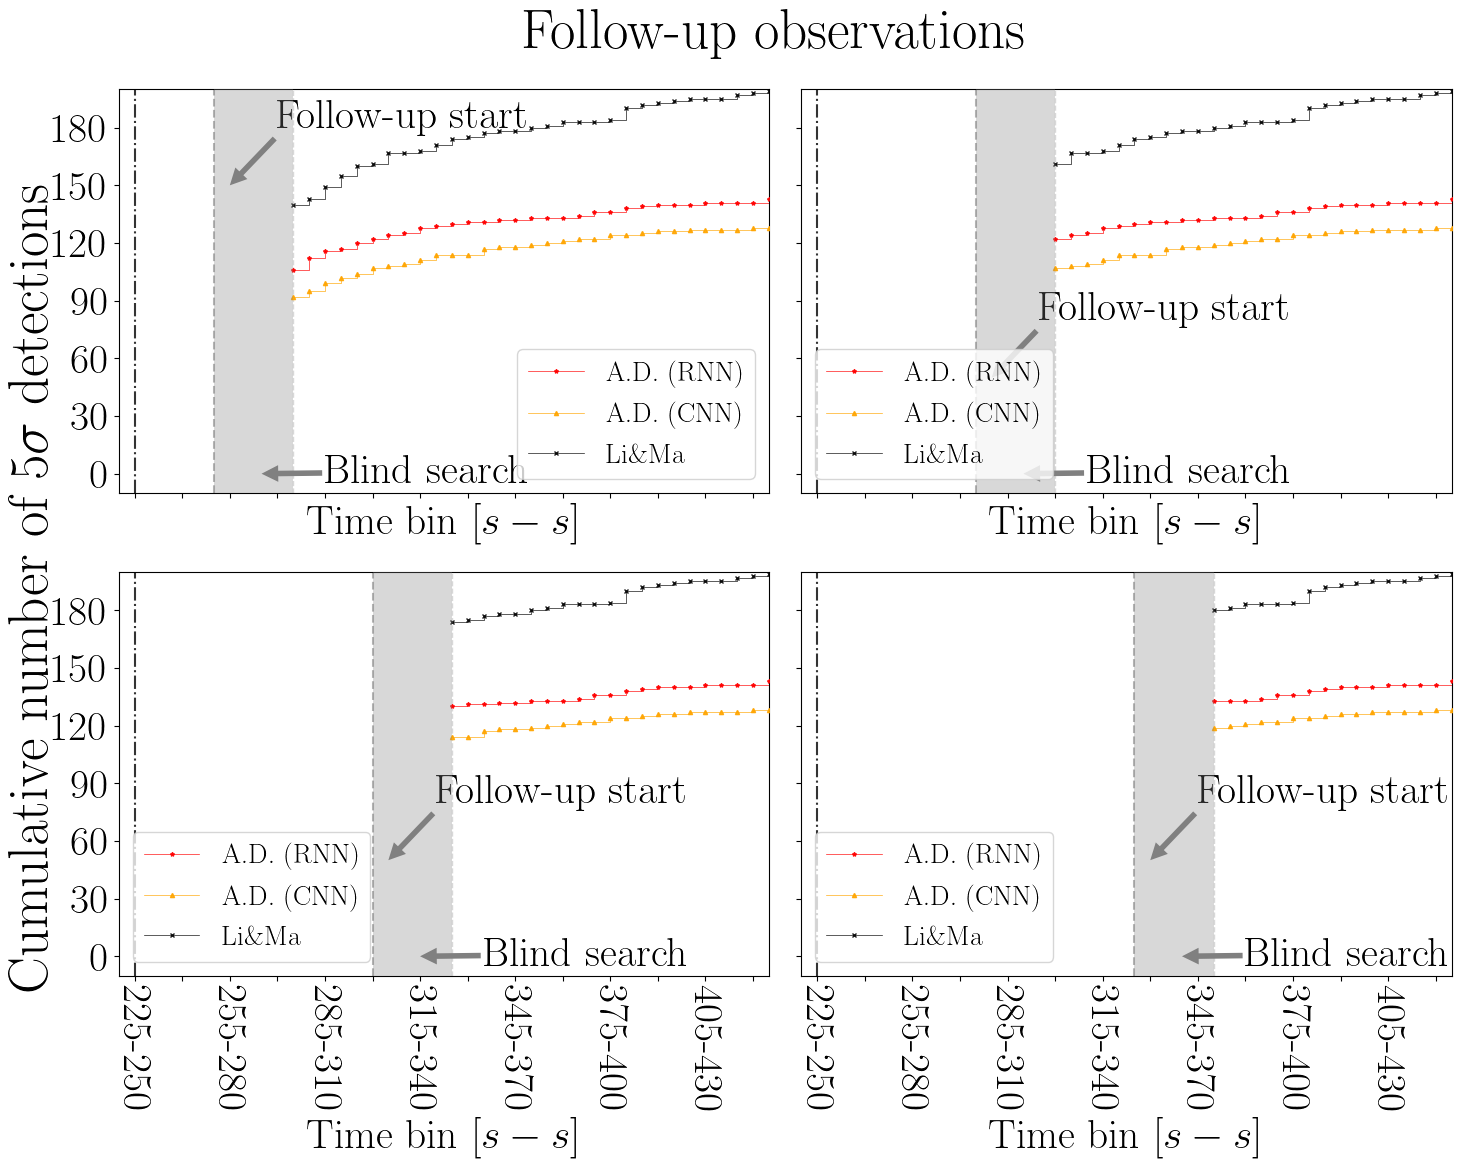

In [88]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches
SIGMA=5
def compute_number_of_detections(tstart):
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,96,1)]
    lima_bins = [i for i in range(tstart,96,1)]

    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
        )
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=30)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=4)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=3, linewidth=0.5, linestyle="-", 
            label="Li\&Ma", color="black", alpha=0.9, zorder=2)

    xticks_x = [i for i in range(45,96,3)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" if i%2!=0 else "" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=30)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,30)])
    yticks_labels = np.array([i for i in yticks_y])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=30)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 60:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 150), fontsize = 30, xytext = (vertical_line_x-5+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 50), fontsize = 30, xytext = (vertical_line_x-5+4, 80), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, 
                                 facecolor="grey", alpha=0.3, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+3, add_rectangle[0][1]+10), fontsize = 30, xytext = (add_rectangle[0][0]+7, add_rectangle[0][1]+5), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(44, stop)
    ax.set_ylim(-10, 200)

    if start < 60:
        ax.legend(markerscale=1, loc="lower right", prop={'size': 20})
    else:
        ax.legend(markerscale=1, loc="lower left", prop={'size': 20})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig2()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(r"Follow-up observations", fontsize=40)
    
    blind_search_grey_rects = [
        [(50, -10), 5, 210],
        [(55, -10), 5, 210],
        [(60, -10), 5, 210],
        [(65, -10), 5, 210]
    ]
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 85, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart], add_rectangle=blind_search_grey_rects[idx])
    fig.text(-0.01, 0.5, r"Cumulative number of $5\sigma$ detections", va='center', rotation='vertical', fontsize=40)

    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5_same_bins.pdf"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5_same_bins.png"), dpi=pc.dpi)
        
follow_up_plot([55, 60, 65, 70])

In [ ]:
list(zip(sigma_table_rnn.index.values, range(0,97)))[43:70]

In [ ]:
SIGMA = 5
#detection_tables(SIGMA,50,55,[60])
#detection_tables(SIGMA,55,60,[65])
#detection_tables(SIGMA,60,65,[70])
#detection_tables(SIGMA,65,70,[75])

In [ ]:
ONSET_INDEX=50
get_dd("rnn",   templates_detections, SIGMA, ONSET_INDEX, 5,   55 ,[55, 60, 65, 70, 75, 80], show_common_only=True)
get_dd("cnn",   templates_detections, SIGMA, ONSET_INDEX, 5,   55 ,[55, 60, 65, 70, 75, 80], show_common_only=True)
get_dd("li_ma", templates_detections, SIGMA, ONSET_INDEX, 5,   55 ,[55, 60, 65, 70, 75, 80], show_common_only=True)

# Sigma plots RNN vs Li&Ma

In [ ]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_rnn, sigma_table_cnn, lima_sigma_table):
    pc = PlotConfig2()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    ax.plot(sigma_table_rnn.index.values, sigma_table_rnn[template], marker='o', linestyle='--', label="Anomaly Detection (RNN)", zorder=2, color="red", alpha=0.8)
    ax.plot(sigma_table_cnn.index.values, sigma_table_cnn[template], marker='o', linestyle='--', label="Anomaly Detection (CNN)", zorder=1, color="orange", alpha=0.8)

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(10, 100, 5):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_rnn.index.values[i])

    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=200, label="Li\&Ma", color="black", zorder=10)
    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    fig.suptitle("Significance variability", fontsize=30)
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel(r"Time bin $\left[s-s\right]$")
    ax.set_ylim(0, 10)
    plt.axvline(x = 45, color = 'grey')
    props = dict(boxstyle='round', facecolor='none', linestyle='-',edgecolor='grey', alpha=0.7)
    ax.text(0.535,0.935,'GRB start',bbox=props, horizontalalignment='center', transform=ax.transAxes)
    
    plt.axhline(y = 3, color = 'black', linestyle="-.")
    plt.axhline(y = 5, color = 'black', linestyle="-.")
    mask = [True if i%2==0 else False for i in range(len(sigma_table_rnn.index.values))]
    ax.set_xticks(range(0, len(sigma_table_rnn.index.values), 2), sigma_table_rnn.index.values[mask], fontsize=17, rotation=-90)
    ax.set_yticks(range(0, 6, 1), range(0, 6, 1), fontsize=17)

    ax.legend()
    outputdir = Path(output_dir).joinpath("detection_plots")
    outputdir.mkdir(exist_ok=True)    
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_5.png"), dpi=100)
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_5.svg"))

    #plt.show()
    plt.close()
    
for template in tqdm(templates_under_investigation):
    sigma_plot(template, sigma_table_rnn, sigma_table_cnn, lima_sigma_table)

In [ ]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,60,[65])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,60,[65])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,60,[65])

In [ ]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,65,[70])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,65,[70])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,65,[70])

In [ ]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,70,[75])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,70,[75])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,70,[75])